In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

In [2]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [3]:
# 2. Load and Normalize Dataset
transform = transforms.Compose([
    transforms.ToTensor(),                 # Convert images to tensor
    transforms.Normalize((0.5,), (0.5,))   # Normalize to [-1, 1]
])

In [4]:
train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_data  = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)


100%|██████████| 26.4M/26.4M [00:01<00:00, 17.8MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 312kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.64MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 8.48MB/s]


In [5]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=64, shuffle=False)

In [6]:
# Class names for visualization
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [7]:
# 3. Define the Neural Network Model
class FashionNet(nn.Module):
    def __init__(self):
        super(FashionNet, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 28*28)   # Flatten image
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = FashionNet().to(device)
print(model)

FashionNet(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)


In [8]:
# 4. Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
# 5. Train the Model
epochs = 10
train_losses = []
train_accuracies = []

In [11]:
for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)
    print(f"Epoch [{epoch+1}/{epochs}] | Loss: {running_loss/len(train_loader):.4f} | Accuracy: {100*correct/total:.2f}%")

print("Training Completed ✅")

Epoch [1/10] | Loss: 0.3191 | Accuracy: 88.17%
Epoch [2/10] | Loss: 0.2954 | Accuracy: 88.99%
Epoch [3/10] | Loss: 0.2776 | Accuracy: 89.71%
Epoch [4/10] | Loss: 0.2642 | Accuracy: 90.23%
Epoch [5/10] | Loss: 0.2520 | Accuracy: 90.70%
Epoch [6/10] | Loss: 0.2403 | Accuracy: 91.06%
Epoch [7/10] | Loss: 0.2308 | Accuracy: 91.29%
Epoch [8/10] | Loss: 0.2165 | Accuracy: 91.88%
Epoch [9/10] | Loss: 0.2096 | Accuracy: 92.14%
Epoch [10/10] | Loss: 0.1994 | Accuracy: 92.40%
Training Completed ✅


In [12]:
# 6. Evaluate on Test Data
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []


In [13]:
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_accuracy = 100 * correct / total
print(f"\n✅ Test Accuracy: {test_accuracy:.2f}%")


✅ Test Accuracy: 87.90%


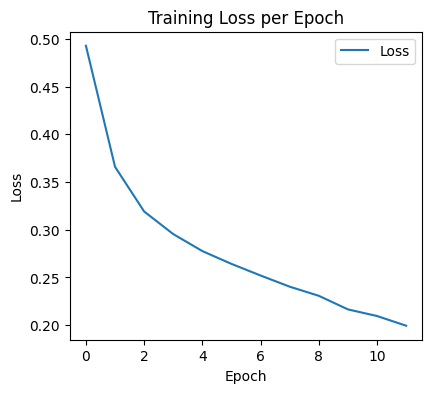

In [14]:
# 7. Plot Training Curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

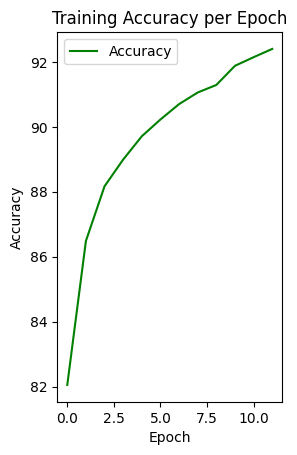

In [15]:
plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Accuracy', color='green')
plt.title('Training Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

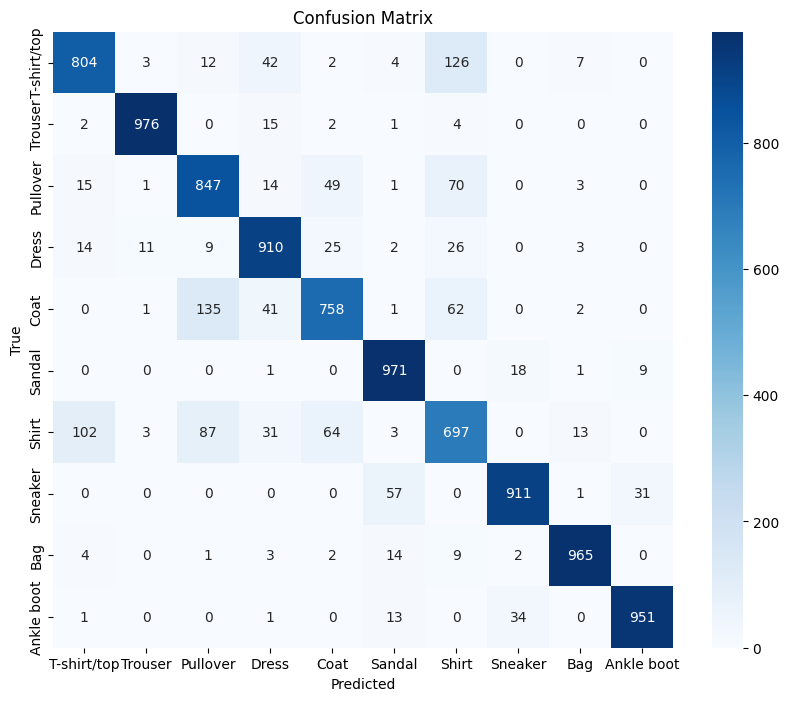

In [16]:
# 8. Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


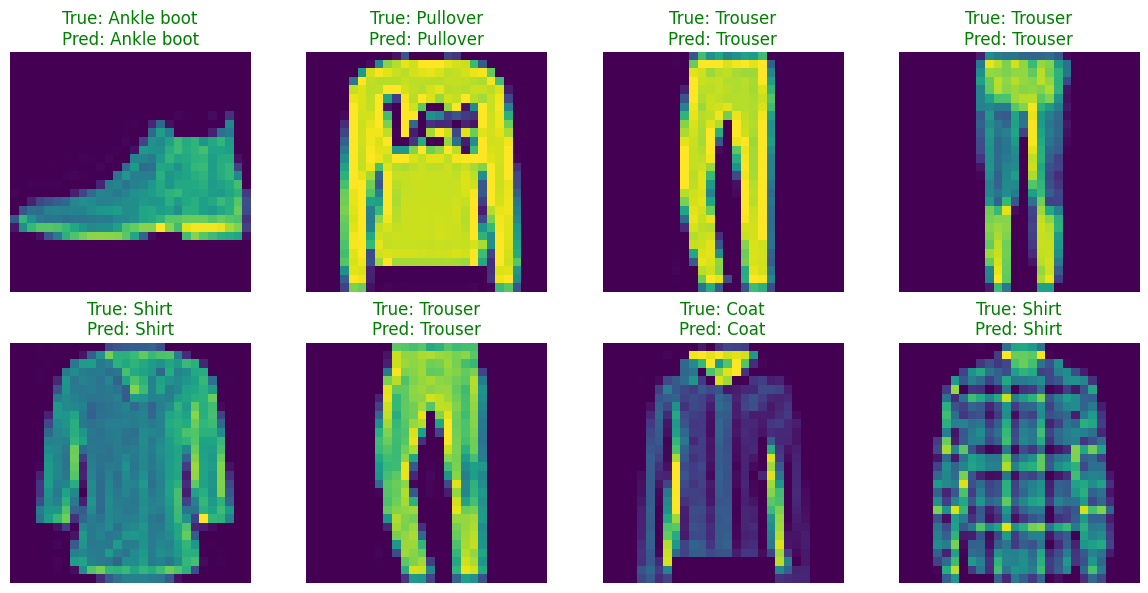

In [17]:
# 9. Show Sample Predictions
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, preds = torch.max(outputs, 1)

plt.figure(figsize=(12,6))
for i in range(8):
    plt.subplot(2,4,i+1)
    imshow(images[i].cpu())
    plt.title(f"True: {classes[labels[i]]}\nPred: {classes[preds[i]]}",
              color=("green" if preds[i]==labels[i] else "red"))
plt.tight_layout()
plt.show()

In [19]:
# 10. Final Results
print(f" Final Training Accuracy: {train_accuracies[-1]:.2f}%")
print(f" Final Test Accuracy: {test_accuracy:.2f}%")

 Final Training Accuracy: 92.40%
 Final Test Accuracy: 87.90%
